
# FinLens AI – SME Credit Risk Explanation Assistant

## Domain
Financial Risk Assessment for SMEs

## Objective
Fine-tune TinyLlama using LoRA to interpret structured SME financial data and produce credit risk explanations.


In [1]:

!pip install transformers peft bitsandbytes accelerate datasets evaluate gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [5]:

import random
import json

def classify_risk(current_ratio, debt_ratio, net_margin):
    risk_score = 0

    if current_ratio < 1:
        risk_score += 2
    elif current_ratio < 1.5:
        risk_score += 1

    if debt_ratio > 0.7:
        risk_score += 2
    elif debt_ratio > 0.5:
        risk_score += 1

    if net_margin < 0:
        risk_score += 2
    elif net_margin < 0.05:
        risk_score += 1

    if risk_score >= 5:
        return "High Risk"
    elif risk_score >= 3:
        return "Moderate Risk"
    else:
        return "Low Risk"

def generate_example():
    revenue = random.randint(50000, 500000)
    debt = random.randint(10000, 400000)
    assets = random.randint(debt + 10000, debt + 500000)

    current_ratio = round(random.uniform(0.5, 2.5), 2)
    net_margin = round(random.uniform(-0.1, 0.2), 2)
    debt_ratio = round(debt / assets, 2)

    risk_level = classify_risk(current_ratio, debt_ratio, net_margin)

    explanation = f"""
The SME has a current ratio of {current_ratio}.
Its debt-to-asset ratio is {debt_ratio}.
The net profit margin is {net_margin}.
 {risk_level} for lending purposes.
"""

    return {
        "instruction": f"Evaluate SME: Revenue {revenue}, Debt {debt}, Assets {assets}, Current Ratio {current_ratio}, Net Margin {net_margin}.",
        "response": explanation.strip()
    }

dataset = [generate_example() for _ in range(1200)]

with open("sme_credit_dataset.json", "w") as f:
    json.dump(dataset, f, indent=2)

print("Dataset Generated")


Dataset Generated


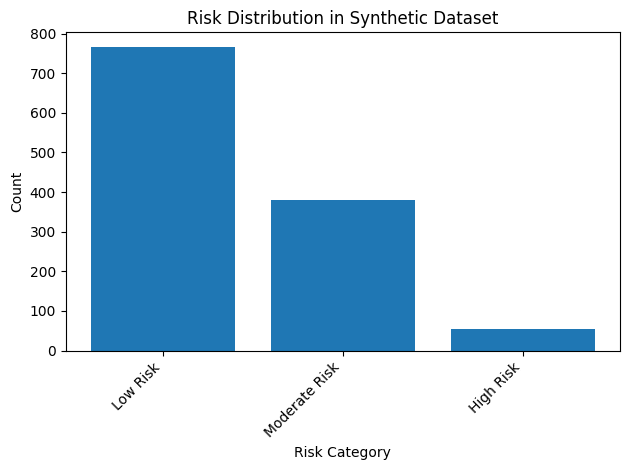

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

def extract_risk_level(response_text):
    if "High Risk" in response_text:
        return "High Risk"
    elif "Moderate Risk" in response_text:
        return "Moderate Risk"
    elif "Low Risk" in response_text:
        return "Low Risk"
    return "Unknown Risk" # Fallback for unexpected format

risk_counts = Counter([extract_risk_level(example["response"]) for example in dataset])

plt.figure()
plt.bar(risk_counts.keys(), risk_counts.values())
plt.title("Risk Distribution in Synthetic Dataset")
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.tight_layout()
plt.show()

In [ ]:

from datasets import load_dataset

dataset = load_dataset("json", data_files="sme_credit_dataset.json")["train"]
dataset = dataset.train_test_split(test_size=0.1)

def format_prompt(example):
    return {
        "text": f"""### Instruction:
{example['instruction']}

### Response:
{example['response']}"""
    }

dataset = dataset.map(format_prompt)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto"
)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def tokenize(example):
    tokenized_inputs = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

In [ ]:

sample_prompt = tokenized_dataset["test"][0]["text"]

inputs = tokenizer(sample_prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=120)

print("BASE MODEL OUTPUT:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


BASE MODEL OUTPUT:
### Instruction:
Evaluate SME: Revenue 275503, Debt 48900, Assets 149801, Current Ratio 0.67, Net Margin 0.18.

### Response:
The SME has a current ratio of 0.67.
Its debt-to-asset ratio is 0.33.
The net profit margin is 0.18.
Overall, this company represents Low Risk for lending purposes.


In [ ]:

from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


In [ ]:

# THREE EXPERIMENTS
from transformers import TrainingArguments, Trainer
import math

def run_experiment(lr, label):
    training_args = TrainingArguments(
        output_dir=f"./finlens_{label}",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        num_train_epochs=2,
        learning_rate=lr,
        logging_steps=10,
        save_strategy="epoch",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"]
    )

    trainer.train()
    eval_results = trainer.evaluate()
    perplexity = math.exp(eval_results["eval_loss"])
    return eval_results["eval_loss"], perplexity

results = {}
results["5e-5"] = run_experiment(5e-5, "exp1")
results["1e-4"] = run_experiment(1e-4, "exp2")
results["3e-5"] = run_experiment(3e-5, "exp3")

print(results)


Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
10,11.717600
20,6.732900
30,4.215300
40,1.813200
50,0.687200
60,0.500900
70,0.431400
80,0.372000
90,0.316200
100,0.260100


Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
10,0.120900
20,0.112400
30,0.108100
40,0.107500
50,0.105900
60,0.106100
70,0.105200
80,0.104800
90,0.103700
100,0.102900


Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
10,0.098800
20,0.099500
30,0.099200
40,0.099400
50,0.098900
60,0.099000
70,0.099000
80,0.098100
90,0.098500
100,0.098800


{'5e-5': (0.1193045899271965, 1.126713051474564), '1e-4': (0.09892857074737549, 1.103987439744739), '3e-5': (0.09823640435934067, 1.103223561142179)}


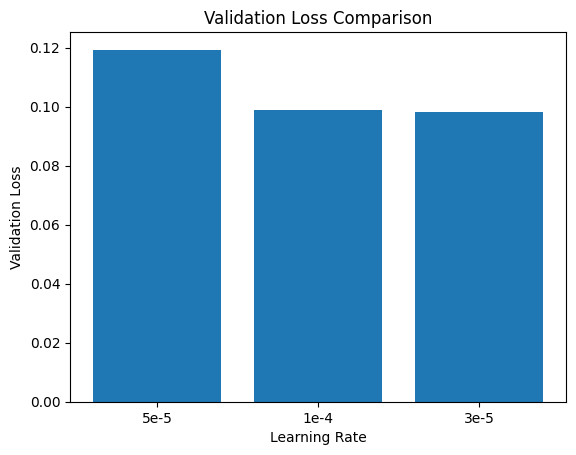

In [ ]:

# Validation Loss Comparison Visualization
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results.keys(), [v[0] for v in results.values()])
plt.title("Validation Loss Comparison")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss")
plt.show()


In [ ]:

# FIXED FINE-TUNED INFERENCE
final_input = """### Instruction:
Evaluate SME: Revenue 200000, Debt 150000, Assets 250000, Current Ratio 0.8, Net Margin 0.02.

### Response:
"""

inputs = tokenizer(final_input, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=120)

print("FINE-TUNED MODEL OUTPUT:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


FINE-TUNED MODEL OUTPUT:
### Instruction:
Evaluate SME: Revenue 200000, Debt 150000, Assets 250000, Current Ratio 0.8, Net Margin 0.02.

### Response:
The SME has a current ratio of 0.8.
Its debt-to-asset ratio is 0.62.
The net profit margin is 0.02.
Overall, this company represents Low Risk for lending purposes.


In [ ]:


def format_prompt(user_query):
    return f"""

Analyze the following SME financial data and provide:
1. Risk Level (High / Medium / Low)
2. Short Explanation (2-3 sentences)
3. Key Financial Warning Signals (if any)

SME Data:
{user_query}

Financial Risk Assessment:"""


def predict_chat_response(user_query):

    prompt = format_prompt(user_query)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_new_tokens=120,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def extract_risk(text):
    if 'High' in text:
        return 'High Risk'
    elif 'Medium' in text:
        return 'Medium Risk'
    elif 'Low' in text:
        return 'Low Risk'
    else:
        return 'Unknown'


# Test Example
result = predict_chat_response(
    "Revenue: 250000, Debt: 180000, Assets: 300000, Current Ratio: 0.8, Net Margin: 0.02"
)

print('RAW MODEL OUTPUT:\n')
print(result)

print('\nFinal Predicted Risk:', extract_risk(result))

RAW MODEL OUTPUT:



Analyze the following SME financial data and provide:
1. Risk Level (High / Medium / Low)
2. Short Explanation (2-3 sentences)
3. Key Financial Warning Signals (if any)

SME Data:
Revenue: 250000, Debt: 180000, Assets: 300000, Current Ratio: 0.8, Net Margin: 0.02

Financial Risk Assessment:
High risk due to high debt load and weak current ratio.
Short explanation: The company has a strong financial position with a current ratio of 0.8. The debt-to-asset ratio is also relatively high.
Key financial warning signals: This company may experience difficulty in servicing its debt obligations in the future.


Final Predicted Risk: High Risk


In [ ]:
def gradio_chat(user_input):
    return predict_chat_response(user_input)

import gradio as gr

iface = gr.Interface(
    fn=gradio_chat,
    inputs="text",
    outputs="text",
    title="FinLens AI - SME Credit Risk Assistant",
    description="Describe the SME’s financials below, and I'll provide a risk assessment and explanation."
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://7b554df0930e08c16a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
